<h1 style="text-align: center;">Tennis Analyzer ML Model V1</h1>
<h3 style="text-align: center;">Dan Warnick</h3>

<p>To start we will begin by selecting the data points we want to analyze with existing known results. For each data entry we will have two players each with the following data entries.</p>
<table style="font-size: .8em;">
    <tr>
        <th>Player Name</th>
    </tr>
</table>
<p>Along with match facts like Clay/Hard/Grass Court or Indoor/Outdoor. In the future may want to add weather and adjust certain parameters for more accuracy and more data points to train from, however for now this seems a good start.</p>

<h2>1.) Collect Data Efficiently</h2>

<p>To gather player name, id, odds, global rank, total win/losses, recent win rate, and average sets in wins/losses we will use ... api. For specific game ratings we will make our own data scraper for the players ranked on each respective genders website, and for surface bias we will use the tennis api from rapid api, and do some calculations within python</p>

In [245]:
import django
from django.http import HttpResponse
from django.template import loader
import os
from django.db import models
import torch
from math import ceil, floor
import numpy as np
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from datetime import datetime
from asgiref.sync import sync_to_async # type: ignore
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import joblib

os.environ.setdefault('DJANGO_SETTINGS_MODULE', 'breakpoint.settings')
django.setup()

from render.models import *

In [128]:
start = '20190101'
end = '20231231'
match_type = 'MensClayEloStats'

In [184]:
start_date = datetime.strptime(start, '%Y%m%d').date()
end_date = datetime.strptime(end, '%Y%m%d').date()

if match_type == 'm':   
    type = MensTennisMatch
    insert_db = MensTennisMatchStats
else:
    type = WomensTennisMatch
    insert_db = WomensTennisMatchStats

query = insert_db.objects.filter(
        tourney_date__range=(start_date, end_date)
    ).order_by('tourney_date')
    
games = await sync_to_async(list)(query.all().values())

df = pd.DataFrame(games).drop(['tourney_id', 'tourney_name', 'tourney_date', 'a_player_name', 'b_player_name', 'a_player_id', 'a_player_slug', 'b_player_id', 'b_player_slug','a_win_percent', 'a_serve_rating', 'a_return_rating', 'a_pressure_rating', 'a_avg_vs_elo', 'a_matches_played', 'b_win_percent', 'b_serve_rating', 'b_return_rating', 'b_pressure_rating', 'b_avg_vs_elo', 'b_matches_played', 'a_odds', 'b_odds'], axis=1)

one_hot_encoder = OneHotEncoder(sparse_output=False)

# One-Hot Encode the 'category_text' column
category_encoded = one_hot_encoder.fit_transform(df[['surface']])

# Convert to DataFrame
category_encoded_df = pd.DataFrame(category_encoded, columns=one_hot_encoder.get_feature_names_out(['surface']))

# Concatenate the one-hot encoded columns back to the original DataFrame
df = pd.concat([df, category_encoded_df], axis=1)

# Drop the original 'category_text' column
df.drop('surface', axis=1, inplace=True)
print(len(df))

11313


In [174]:
df.head()

,id,best_of,match_num,a_player_rank,b_player_rank,a_elo_rating,a_point_elo_rating,a_game_elo_rating,a_set_elo_rating,a_service_game_elo_rating,...,b_surface_point_elo_rating,b_surface_game_elo_rating,b_surface_set_elo_rating,b_surface_service_game_elo_rating,b_surface_return_game_elo_rating,b_surface_tie_break_elo_rating,a_b_win,surface_Clay,surface_Grass,surface_Hard
0,2825.0,3.0,292.0,49.0,46.0,1677.0,1527.0,1575.0,1657.0,1590.0,...,1532.0,1559.0,1633.0,1620.0,1556.0,1640.0,1.0,0.0,0.0,1.0
1,2826.0,3.0,291.0,346.0,86.0,1604.0,1508.0,1518.0,1546.0,1504.0,...,1514.0,1527.0,1602.0,1418.0,1609.0,1573.0,1.0,0.0,0.0,1.0
2,2827.0,3.0,290.0,54.0,47.0,1670.0,1492.0,1506.0,1603.0,1547.0,...,1516.0,1528.0,1546.0,1455.0,1636.0,1355.0,0.0,0.0,0.0,1.0
3,2828.0,3.0,289.0,51.0,77.0,1635.0,1505.0,1538.0,1614.0,1545.0,...,1474.0,1430.0,1503.0,1393.0,1524.0,1495.0,0.0,0.0,0.0,1.0
4,2829.0,3.0,287.0,59.0,63.0,1757.0,1578.0,1651.0,1764.0,1639.0,...,1519.0,1559.0,1653.0,1524.0,1590.0,1494.0,1.0,0.0,0.0,1.0


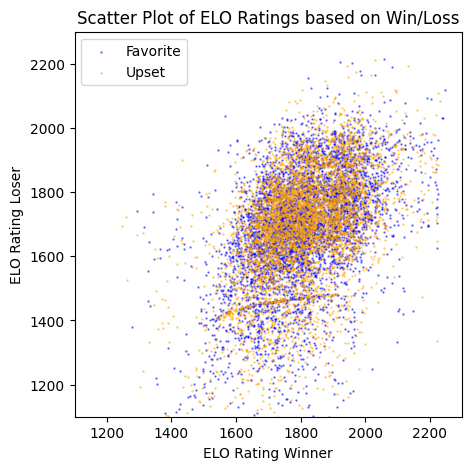

In [146]:
# Create a scatter plot
plt.figure(figsize=(5, 5))

# Plot a_elo_rating vs b_elo_rating for a_b_win == 1
plt.scatter(df[df['a_b_win'] == 1]['a_elo_rating'], df[df['a_b_win'] == 1]['b_elo_rating'], color='blue', label='Favorite', s=.5, alpha=0.5)

# Plot b_elo_rating vs a_elo_rating for a_b_win == 0
plt.scatter(df[df['a_b_win'] == 0]['b_elo_rating'], df[df['a_b_win'] == 0]['a_elo_rating'], color='orange', label='Upset', s=.5, alpha=0.5)
plt.xlim(1100, 2300)
plt.ylim(1100, 2300)

# Adding labels and title
plt.xlabel('ELO Rating Winner')
plt.ylabel('ELO Rating Loser')
plt.title('Scatter Plot of ELO Ratings based on Win/Loss')
plt.legend()

# Show the plot
plt.show()

In [147]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [151]:
class OutcomeProbability(nn.Module):
    def __init__(self, input_dim=36):
        hidden_dim=int(input_dim * (2/3))
        super(OutcomeProbability, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # No sigmoid activation here
        return x


In [237]:
df = df.dropna()

y = df['a_b_win'].values
X = df.drop('a_b_win', axis=1).values

# Standardize the features
# RESEARCH FURTHER - AFFECTS ACCURACY
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Save the fitted scaler to a file - future entries
# joblib.dump(scaler, 'scaler.joblib')

# Split the data into training (2/3) and testing (1/3) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42)

# Convert the data to PyTorch tensors
train_dataset = data.TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_dataset = data.TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

# Create DataLoader objects
batches = 32
train_loader = data.DataLoader(train_dataset, batch_size=batches, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=batches, shuffle=False)

# Initialize the model, loss function, and optimizer
model = OutcomeProbability(input_dim=X.shape[1])
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = ceil(len(X_train) / batches) #400-500 worked well but this does too
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        # print(f"Inputs: {inputs} \nOutputs: {outputs}")
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    if((epoch+1)%25==0):
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Testing loop
model.eval()
predictions = []
actuals = []
with torch.no_grad():
    test_loss = 0
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        predictions.extend(torch.sigmoid(outputs))
        actuals.extend(labels.numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f'Test Loss: {test_loss/len(test_loader):.4f}, Accuracy: {accuracy:.2f}%')

predictions = np.array(predictions)
actuals = np.array(actuals)

Epoch [25/232], Loss: 0.4457
Epoch [50/232], Loss: 0.1601
Epoch [75/232], Loss: 0.2650
Epoch [100/232], Loss: 0.2097
Epoch [125/232], Loss: 0.2218
Epoch [150/232], Loss: 0.1456
Epoch [175/232], Loss: 0.1774
Epoch [200/232], Loss: 0.2800
Epoch [225/232], Loss: 0.1280
Test Loss: 0.2605, Accuracy: 89.49%


In [247]:
correct = 0
total = 0
incorrect = 0
for i in range(len(predictions)):
    if round(predictions[i]) == actuals[i]:
        correct+=1
    else:
        incorrect+=1

    total+= 1
    if(i%300 == 0):
        print(f"Prediction Odds: {predictions[i]:.2f} vs Outcome: {actuals[i]:.0f}")

print(f"{correct} / {total} = {correct/total}")
print(f"{incorrect} / {total} = {incorrect/total}")

Prediction Odds: 0.89 vs Outcome: 1
Prediction Odds: 0.96 vs Outcome: 1
Prediction Odds: 0.00 vs Outcome: 0
Prediction Odds: 0.00 vs Outcome: 0
Prediction Odds: 0.01 vs Outcome: 0
Prediction Odds: 0.98 vs Outcome: 1
Prediction Odds: 0.96 vs Outcome: 1
Prediction Odds: 0.23 vs Outcome: 0
Prediction Odds: 0.00 vs Outcome: 0
Prediction Odds: 0.98 vs Outcome: 1
Prediction Odds: 0.00 vs Outcome: 0
Prediction Odds: 0.18 vs Outcome: 0
Prediction Odds: 0.96 vs Outcome: 1
3319 / 3709 = 0.8948503639795093
390 / 3709 = 0.1051496360204907
